# NHS Patient Q&A  


In [ ]:
!pip install evaluate
!pip install rouge_score
!pip install bert_score

In [ ]:
#Libraries/ packages used throughtout this project, please run prior to
import pandas as pd
import numpy as np
import os
import string
import re
import matplotlib.pyplot as plt
from datasets import Dataset
from google.colab import files, drive
import traceback
from pathlib import Path #needed to improve procssing speed
from sklearn.model_selection import train_test_split
import evaluate
from transformers import AutoTokenizer, T5ForConditionalGeneration, Seq2SeqTrainer, Seq2SeqTrainingArguments, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, EarlyStoppingCallback
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [ ]:
# Needed if Google collab and the data is stored in local google drive:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Please note: Adapt the local directiory to run the subsequent script
# Loading data from local directionary
trainds = pd.read_csv("/content/drive/My Drive/Colab Notebooks/AMLH-NLP EHR/patient_qa_train.csv",sep=",", dtype=str)
testds = pd.read_csv("/content/drive/My Drive/Colab Notebooks/AMLH-NLP EHR/patient_qa_test.csv",sep=",", dtype=str)
NHS_documents_wd = Path("/content/drive/My Drive/Colab Notebooks/AMLH-NLP EHR/db_nhs_qa")

## Section 1.0: Exploratory data anlysis (EDA) for provided data


In [ ]:
#EDA: Exploratory data analysis trainds
print(f"train df shape:{trainds.shape}: {trainds.columns}")
#EDA: Exploratory data analysis testds
print(f"test df shape:{testds.shape}: {testds.columns}")

# Looking at the disease column of the dataset to understand
#what conditions the provided answers are related to
disease_uniqu = trainds['disease'].unique()
diagnosis_counts = trainds['disease'].value_counts()

print(f"Disease distribution: {diagnosis_counts}")
print(f"Disease distribution: {disease_uniqu}")  #Nr. of diseases discusesed 2392
print(diagnosis_counts.head(20))
#Observation diseases column do not only repsents diseases or conditions
#but medical circumstances, alonside a seperator "/", which requires furhter cleaninign later on
#the corresponding descriptions may be important later for the models context:

train df shape:(24005, 4): Index(['question', 'answer', 'disease', 'reference_url'], dtype='object')
test df shape:(211, 4): Index(['question', 'answer', 'disease', 'reference_url'], dtype='object')
Disease distribution: disease
breast cancer/treatment                                20
contraception/the pill progestogen only                20
fibroids/treatment                                     20
first aid                                              20
pregnancy and baby/infectious illnesses children       20
                                                       ..
dialysis/side effects                                  10
dialysis/what happens                                  10
diarrhoea and vomiting                                 10
diabetic ketoacidosis                                  10
pregnancy and baby/twins healthy multiple pregnancy     5
Name: count, Length: 2392, dtype: int64
Disease distribution: ['Bronchiolitis' 'Bronchitis' 'Laryngitis' ... 'x ray' 'yellow fever'
 

In [ ]:
#Descriptive statisics for display in the report Section 1.0: Introduction
#Exploring the character lengths of both the answers and questions within the dataset
trainds["question_length"] = trainds["question"].apply(lambda x: len(str(x).split()))
trainds["answer_length"] = trainds["answer"].apply(lambda x: len(str(x).split()))
#Exploring the descriptive stats for both answers and questions' characters:
print("\n Question word length stats:")
print(trainds["question_length"].describe())
print("\n Answer word length stats:")
print(trainds["answer_length"].describe())


 Question word length stats:
count    24005.000000
mean         8.920225
std          3.671865
min          3.000000
25%          6.000000
50%          9.000000
75%         11.000000
max         29.000000
Name: question_length, dtype: float64

 Answer word length stats:
count    24005.000000
mean        41.355884
std         19.516501
min          4.000000
25%         27.000000
50%         38.000000
75%         52.000000
max        262.000000
Name: answer_length, dtype: float64


In [ ]:
#Descriptive statisics for display in the report Section 1.0: Introduction
#Exploring the character lengths of both the answers and questions within the dataset
trainds["question_length"] = trainds["question"].apply(lambda x: len(str(x).split()))
trainds["answer_length"] = trainds["answer"].apply(lambda x: len(str(x).split()))
#Exploring the descriptive stats for both answers and questions' characters:
print("\n Question word length stats:")
print(trainds["question_length"].describe())
print("\n Answer word length stats:")
print(trainds["answer_length"].describe())


 Question word length stats:
count    24005.000000
mean         8.920225
std          3.671865
min          3.000000
25%          6.000000
50%          9.000000
75%         11.000000
max         29.000000
Name: question_length, dtype: float64

 Answer word length stats:
count    24005.000000
mean        41.355884
std         19.516501
min          4.000000
25%         27.000000
50%         38.000000
75%         52.000000
max        262.000000
Name: answer_length, dtype: float64


## Section 2.0: Data Preprocessing (TF:IDF)


In [ ]:
# Firstly, for the downstream implentaion of TF-IDF, the
#Here the fetch_by_diagnosis function, was initally applied combined with safe_filename,
#though the processing speed was immensly affected, as such a simple corpus build was decided for
def safefilename(name):
    """ Mapps the disease label to the matching NHS document in ./db_nhs_qa,Provided from the assignment brief, for """
    cle= re.sub(r'[^a-zA-Z0-9 ]', '_', name.strip().lower())
    cle= re.sub(r'\s+', '_', cle)
    cle= re.sub(r'_+', '_', cle)
    return cle +".txt"
fi = {fn.name.lower(): fn for fn in NHS_documents_wd.iterdir() if fn.suffix == ".txt"}

#For this TF-IDF context, a corpus needs to be setup/build
#loading/fetching all documents using the fetch_by_diagnosis function above
#Herein only unqiue disease will be included, for a more valid evalution less
corps_txt= { }
miss= []
for d in trainds["disease"].unique():
    dname = safefilename(d)
    if dname in fi:
        corps_txt[d] = fi[dname].read_text(encoding="utf-8")
    else:
      miss.append(d)
#Checking how many files were loaded in the corpus
print(f"{len(corps_txt)}, {len(miss)}")

2392, 0


In [ ]:
# Data Cleaning: In preperation for TF:IDF Implementation, as outlined in Section 2.1.2
# Text standarsiation, includes lowercasing, removing puncutation or furhter symbols like hyphens and /, whitepsecaes
# Removal of stopwords is conducted later in the

#Creating a copy of the used datasets, to enusure seperate and clean application for both models
train_ds_idf_copy= trainds.copy()
test_ds_idf_copy= testds.copy()

#Creating a function for efficient, data cleaning (text standardisation),
def standardisation_txt(txt_for_standard):
  """ The following function ensures efficient cleaning of text,
      hereby lowercasing, removing puncuation, hyphens and slashes  as well as unnesssary whitespaces: A step needed for TF:IDF """
  txt_for_standard= str(txt_for_standard)
  txt_for_standard= txt_for_standard.lower()
  txt_for_standard= re.sub(r"[\n\t]", ' ', txt_for_standard)
  txt_for_standard= re.sub(r"[-/]", " ", txt_for_standard)
  txt_for_standard = txt_for_standard.translate(str.maketrans('', '', string.punctuation))
  txt_for_standard = re.sub(r'\s+', ' ', txt_for_standard).strip()
  return txt_for_standard

# Application of the standardisation_txt function, for the cleaning of the relvaent columns and documents and corpus
# employed for TF-IDF implementation
corps_IDF_ready_values = [standardisation_txt(doc) for doc in corps_txt.values()]
corps_IDF_ready_keys = list(corps_txt.keys())
train_ds_idf_copy["question"]= train_ds_idf_copy["question"].apply(standardisation_txt)
train_ds_idf_copy["answer"]= train_ds_idf_copy["answer"].apply(standardisation_txt)
test_ds_idf_copy["question"]= test_ds_idf_copy["question"].apply(standardisation_txt)
test_ds_idf_copy["answer"]= test_ds_idf_copy["answer"].apply(standardisation_txt)

In [ ]:
## Remove any leadin from '\ufeff each document’s text
corps_IDF_ready_values= [doc.lstrip('\ufeff') for doc in corps_IDF_ready_values]
corps_IDF_ready_keys= [doc.lstrip('\ufeff') for doc in corps_IDF_ready_keys]

In [ ]:
#vecotorising the corpus values: Addding the removal of stopwords via (stop_words='english'), part of precrocessing mentioned in report section 2.1.2
vectoriser = TfidfVectorizer(stop_words='english',ngram_range=(1,2))
# max_features=5000 was too harsh on the retrieval cutoff,
#afftecting the cosine similarity score, hence why it was left out as a parameter
corpsvect_ = vectoriser.fit_transform(corps_IDF_ready_values)

## Section 3.0: TF-IDF Implementation

In [ ]:
## Implementing the retk_docs, a function that implemtned TF-IDF for the document retrieval
def retk_docs(question: str, k: int = 3):
    """Thsi function retruns the document with the highest ranking via (disease_label, snippet, score) tuples for `question`."""
    #Applying the standarsisation fuction from the code upstream,
    # to clean the input question
    stand_q = standardisation_txt(question)
    #Vecorisation of the standardised input question
    vexq   = vectoriser.transform([stand_q])
    #Computing the cosine similarities against all docs
    cosine_S  = cosine_similarity(vexq, corpsvect_).flatten()
    #Filtering the question/docuemnt ouputs with the highest cosine_similarity scores
    top_idxs = np.argsort(cosine_S)[::-1][:k]
    #Storing the results in a list witht the question, corresponding document and cosien similiaryt score.
    results = []
    for idx in top_idxs:
        question =corps_IDF_ready_keys[idx]
        document =corps_IDF_ready_values[idx]
        score = cosine_S[idx]
        results.append((question, document, score))
    return results

##Section 4: TF-IDF MODEL Evaluation

Section 4.1: Visual Inspection of Tf-IDF output

In [ ]:
#Visiual inspection of some one results:
egp_1 = test_ds_idf_copy.loc[0, "question"]
egp_2 = test_ds_idf_copy.loc[6, "question"]

#taking the best ranked outputs for display
bestranked_ouputs = retk_docs(egp_1, k=3)
print(f"Input qustion: {egp_1} ?")
for rank, (question, document, score) in enumerate(bestranked_ouputs, 1):
    print(f"rank {rank}: {question} (score {score:.2f})")
    print(f"NHS document: {document}")

#Looking throgh the next three examples with egp_2
bestranked_ouputs = retk_docs(egp_2, k=3)
print(f"Input qustion: {egp_2}?")
for rank, (question, document, score) in enumerate(bestranked_ouputs, 1):
    print(f"Rank NR {rank}: {question} (score {score:.2f})")
    print(f"NHS document: {document}")

Input qustion: what is bronchiolitis ?
rank 1: Bronchiolitis (score 0.54)
NHS document:  bronchiolitis nhs skip to main content bronchiolitis bronchiolitis is a common chest infection that affects babies and children under 2 its usually mild and can be treated at home but it can be serious bronchiolitis is different from bronchitis which causes a cough with lots of mucus and can affect people of all ages check if its bronchiolitis the early symptoms of bronchiolitis are similar to a cold such as sneezing a runny or blocked nose a cough and a slightly high temperature of 38c a child with bronchiolitis may then get other symptoms such as breathing more quickly finding it difficult to feed or eat noisy breathing wheezing becoming irritable symptoms are usually worst between days 3 and 5 and the cough usually gets better in 3 weeks immediate action required call 999 or go to ae if your child is having difficulty breathing – you may notice grunting noises or their tummy sucking under their 

In [ ]:
rg= evaluate.load("rouge")
sm = SmoothingFunction().method

Section 4.2: Computing Performance metrics for TF-IDF

In [ ]:
#Function computing recall pformance at a specified
def recallk(d, k=1):
    """ Function calculcating the TF-IDF output, at a specified k(document ranking,
        with 1 being top ranked document based on cosine similarity)  """
    cm = 0
    pateint_ques= d["question"].tolist()
    true_labels = d["disease"].tolist()
    for question, true_label in zip(pateint_ques, true_labels):
        t_k = [label for label, _, _ in retk_docs(question, k=k)]
        if true_label in t_k:
          cm  += 1
    return cm/len(d)

#applying the recallk function to calculate the recall pefromance at k1 and 3 (documents ranked)
r_ranked1 = recallk(test_ds_idf_copy, k=1)
r_ranked3 = recallk(test_ds_idf_copy, k=3)
#Calculating the Precion,recall and f1 scors, treating dieases as classes
yt= test_ds_idf_copy["disease"].tolist()
yp =[retk_docs(q, k=1)[0][0] for q in test_ds_idf_copy["question"].tolist()]
p1 =precision_score(yt, yp, average="micro")
r1c = recall_score(yt, yp, average="micro")
f1   = f1_score(yt, yp, average="micro")
#Inlcuding top retreived documents into the test set
test_ds_idf_copy["tfidf_prediction"] = [retk_docs(q, k=1)[0][1]  for q in test_ds_idf_copy["question"]]
#Computing the Rouge scores
pred_ = test_ds_idf_copy["tfidf_prediction"].tolist()
ref_s  = test_ds_idf_copy["answer"].tolist()
rg_scored = rg.compute(predictions=pred_, references=ref_s,rouge_types=["rouge1","rouge2","rougeL"],use_stemmer=True)
#Computing the bleu scores
bl_score = [sentence_bleu([ref.split()], pred.split(),weights=(.25,.25,.25,.25),smoothing_function=sm) for pred, ref in zip(pred_,ref_s)]
mean_bleu = sum(bl_score) / len(bl_score)
# Preparing the results for display analysis formmat
tfidf_R = {"Recall k1": r_ranked1,
           "Recall k3":r_ranked3,
           "Precision k1": p1,
           "Recall (class 1)": r1c,
           "F1 score (class 1)": f1,
           "Rouge 1": rg_scored["rouge1"],
           "Rouge 2": rg_scored["rouge2"],
           "Rouge L": rg_scored["rougeL"],
           "Bleu-4": mean_bleu}
print(tfidf_R )
#Downloading and printingthe results
pd.DataFrame([tfidf_R]).to_csv("tfidfeval.csv", index=False)
files.download("tfidfeval.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Section 5: T5-small pre-processing



In [ ]:
##Please note: Adapt the local directiory to run the subsequent script
#Reloading the datasets used for T5 fine-tuning
train_t5_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/AMLH-NLP EHR/patient_qa_train.csv",sep=",", dtype=str)
test_t5_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/AMLH-NLP EHR/patient_qa_test.csv",sep=",", dtype=str)
T5_NHS_documents = Path("/content/drive/My Drive/Colab Notebooks/AMLH-NLP EHR/db_nhs_qa")

In [ ]:
# Importing the model and its tokeniser
t5_m = "t5-small"
tokense_t5 = AutoTokenizer.from_pretrained(t5_m)
model = T5ForConditionalGeneration.from_pretrained(t5_m)

#Setting up t5s purpose as the model has different tasks/functions it can be set to:
if t5_m  in ["t5-small"]:
    prefix = "question "
else:
    prefix = ""

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
#Standardsiging/cleaning the text for T5-fine tuning
#lowecasing and removing white spaces
def T5_standardisation_txt(T5txt_for_standard):
  """ The following function ensures efficient cleaning of text,
      hereby lowercasing and unnesssary whitespaces: A step needed for the T5 model"""
  T5txt_for_standard= T5txt_for_standard.lower()
  T5txt_for_standard= re.sub(r'\s+', ' ', T5txt_for_standard).strip()
  return T5txt_for_standard

#Aplying this standardisation function to relavant columns
train_t5_df["question_clean"]= train_t5_df["question"].apply(T5_standardisation_txt)
train_t5_df["answer_clean"]= train_t5_df["answer"].apply(T5_standardisation_txt)
train_t5_df["disease_clean"] = train_t5_df["disease"].apply(T5_standardisation_txt)
# test_t5_df["question_clean"]= test_t5_df["question"].apply(T5_standardisation_txt) #Not apllied to improve model generalisaiton abbillty
# test_t5_df["answer_clean"]= test_t5_df["answer"].apply(T5_standardisation_txt)

In [ ]:
unique_diseases = train_t5_df["disease_clean"].unique()
print("Nr unique diseases", len(unique_diseases))

Nr unique diseases 2392


In [ ]:
search_data_dir = T5_NHS_documents
# Standardising file naames
def safe_filename(name):
    return re.sub(r'[^\w\-_. ]', '_', name).strip().replace(" ", "_") + ".txt"
# Index all available .txt files in the folder
file_index = {fn.name.lower(): fn for fn in T5_NHS_documents.iterdir() if fn.suffix == ".txt"}
#Creating the corpus and mapping each disease to the corresponding documents
cor_txt = {}
missed_desiease = []
for disease in train_t5_df["disease_clean"].unique():
    fname = safe_filename(disease)
    if fname in file_index:
      cor_txt[disease]= file_index[fname].read_text(encoding="utf-8")
    else:
        missed_desiease.append(disease)
train_t5_df["NHS_docuemntsclean"] = train_t5_df["disease_clean"].map(cor_txt)

# Creating the inputs for t5 in the appropriate dataframe
train_t5_df["target_text"] = train_t5_df["answer_clean"]
train_t5_df["input_text"] = train_t5_df.apply(lambda row: f"question: {row['question_clean']} context: {row['NHS_docuemntsclean']}", axis=1)

In [ ]:
#splitting the training data into a 80/20 training, validation set split
train_T5, val_T5 = train_test_split(train_t5_df[["input_text", "target_text", "disease_clean"]], test_size=0.2, stratify=train_t5_df["disease_clean"], random_state=42)

In [ ]:
max_doc_len = 512
max_sum_length = 64
prefix = "question: "

def preprocesssamples(samples):
    inputs = [prefix + doc for doc in samples["input_text"]] #Adding the prefix here
    # Tokenising the input
    model_inputs = tokense_t5(inputs, max_length=max_doc_len, truncation=True, padding="max_length")
    #tokenising the labels
    with tokense_t5.as_target_tokenizer():
      targets = tokense_t5(text_target = samples["target_text"], max_length=max_sum_length, truncation=True, padding="max_length")
      model_inputs["labels"] = targets["input_ids"]
      return model_inputs

# Converting to hugging face dataset
train_T5_ = Dataset.from_pandas(train_T5[["input_text", "target_text"]].reset_index(drop=True))
val_T5_ = Dataset.from_pandas(val_T5[["input_text", "target_text"]].reset_index(drop=True))

#Appplyign the preprocesssamples function
token_train_T5_final = train_T5_.map(preprocesssamples, batched=True)
token_val_T5_final = val_T5_.map(preprocesssamples, batched=True)
print(token_train_T5_final[0])

Map:   0%|          | 0/19204 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3951: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/4801 [00:00<?, ? examples/s]

{'input_text': "question: what are the advantages of a mechanical valve for aortic valve replacement? context: \ufeff\n\nAortic valve replacement - What happens\n - NHS\n\nSkip to main content\n\nWhat happens\n \n - \n Aortic valve replacement\n \n\nAn aortic valve replacement is a major operation and will only be carried out if you're well enough to have surgery.\n\nPreparing for the operationIn the weeks before the procedure, you'll attend a pre-admission clinic for an assessment to check whether the operation is suitable.\nThis is also a good time to ask any questions you have about the procedure.\nAs part of this assessment, you may:\nhave a physical examination\nbe asked about your medical history, including any medication you're taking, any\xa0allergies you have and whether you have had a reaction to\xa0anaesthesia in the past\nhave\xa0tests to check your general and heart health –\xa0these\xa0may include a blood test,\xa0X-ray,\xa0electrocardiogram (ECG) and echocardiogram\nIf y

## Section 6: Fine-tuninig T5-small & Evaluating


In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #Manually swtiched to in google collab
data_collator = DataCollatorForSeq2Seq(tokenizer=tokense_t5, model=model)

#Detailling the necessary training condtionons, justified and furhter dicussed in sections 2.1.3 & 2.2.2 in the correspoding report
batchsize = 8
trainargs = Seq2SeqTrainingArguments(output_dir="./t5_qa_model",
                                     eval_strategy = "epoch",
                                     learning_rate=2e-5,
                                     per_device_train_batch_size=batchsize,
                                     per_device_eval_batch_size=batchsize,
                                     weight_decay=0.01,
                                     save_total_limit=2,
                                     num_train_epochs=6,
                                     predict_with_generate=True,
                                     push_to_hub=False,
                                     report_to="none",
                                     logging_dir="./logs",
                                     logging_steps=10,
                                     save_strategy="epoch",
                                     metric_for_best_model="eval_loss",
                                     greater_is_better=False,)

In [ ]:
def model_init():
    return AutoModelForSeq2SeqLM.from_pretrained("t5-small")

In [ ]:
# Setting up & training th t5 small model, thereby evaluation metrics as well
t5trainer= Seq2SeqTrainer(
    model_init=model_init,
    args=trainargs,
    train_dataset=token_train_T5_final,
    eval_dataset=token_val_T5_final,
    tokenizer=tokense_t5,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)])
t5trainer.train() #training the model here

/tmp/ipython-input-24-942816049.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  t5trainer= Seq2SeqTrainer(
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,1.545600,1.481636
2,1.464400,1.444403
3,1.466400,1.419544
4,1.440500,1.408478
5,1.678800,1.402640
6,1.453500,1.399771


TrainOutput(global_step=14406, training_loss=1.5663738258676398, metrics={'train_runtime': 4955.2322, 'train_samples_per_second': 23.253, 'train_steps_per_second': 2.907, 'total_flos': 1.5594623732809728e+16, 'train_loss': 1.5663738258676398, 'epoch': 6.0})

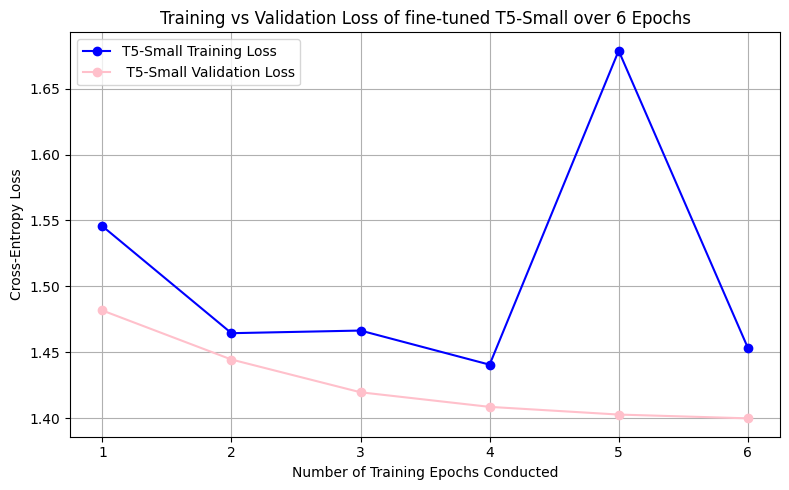

In [ ]:
# Visulalising the Loss overtime during training per epoch, for the trainign and validation set
epoc = [1, 2, 3, 4, 5, 6]
obtained_trainloss = [1.545600, 1.464400, 1.466400, 1.440500, 1.678800, 1.453500]
obtained_vlalloss = [1.481636, 1.444403, 1.419544, 1.408478, 1.402640, 1.399771]
#Customising and plotting the training versus validation loss
plt.figure(figsize=(8, 5))
plt.plot(epoc,obtained_trainloss, marker='o',color='blue',label='T5-Small Training Loss')
plt.plot(epoc,obtained_vlalloss, marker='o', color='pink', label=' T5-Small Validation Loss')
plt.xlabel('Number of Training Epochs Conducted')
plt.ylabel('Cross-Entropy Loss')
plt.title('Training vs Validation Loss of fine-tuned T5-Small over 6 Epochs')
plt.xticks(epoc)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print(trainargs.output_dir) # Checking where the model was put

./t5_qa_model


In [ ]:
bertscore = evaluate.load("bertscore") # loading the bertscore
rg = evaluate.load("rouge") #loading rouge metics and its correpsonding
smooth= SmoothingFunction().method1 #smoothing feature for the BLEU sores

# # #Defining an evaluation functions which computes the tokenised precicion, recall, F1score metrics
# # #alongside the bleu and rouge metrics, which later will be computed in the training loop
def comp_mt(el_pd):
    preds_, labels_ =el_pd
    #Ensuring preds_, labels_ are in numpy format and on cpu
    if isinstance(preds_, torch.Tensor):
        preds_ =preds_.cpu().numpy()
    if isinstance(labels_, torch.Tensor):
        labels_ =labels_.cpu().numpy()
    #Due to OverflowError in the past, replacing -100 labels with token IDs,avoiding decoding issuees
    #Since Pytorch ignored these indexes
    labels_ =np.where(labels_ != -100, labels_, tokense_t5.pad_token_id)
    try:
        #Due to ongoing OverflowErrors error enountered during evalution, the intseq was created
        #Converiting sequences of tokenids into integers via intseq, avoiding decoding issues encountered earlier
        def intseq(sq):
            sq = [int(min(max(tok, 0), 2**31 - 1)) for tok in list(sq)] if hasattr(sq, '__iter__') else [int(min(max(sq, 0), 2**31 - 1))]
            return sq
        #Decoding the tokens into strings for evaluation
        deco_preds_ =tokense_t5.batch_decode([safe_int_seq(seq) for seq in preds_], skip_special_tokens=True)
        decod_labels_ =tokense_t5.batch_decode([safe_int_seq(seq) for seq in labels_], skip_special_tokens=True)
        #tokensing each word, and flattening for evaluation
        pd_tok=[gen.split() for gen in deco_preds_]
        ref_tok=[ref.split() for ref in decod_labels_]
        ypred = [token for sent in pd_tok for token in sent]
        y_ref = [token for sent in ref_tok for token in sent]
        #truncating for alignment between both the refernce and prediciotns
        minlength=min(len(y_ref), len(ypred))
        ypred = ypred[:minlength]
        y_ref =y_ref[:minlength]
        #Computing precision, recall, accuracy and the F-1 score, each for word-token comparison between reference and prediction
        tokprec_=precision_score(y_ref, ypred, average="micro", zero_division=0)
        tokrecall =recall_score(y_ref, ypred, average="micro", zero_division=0)
        tokf1_= f1_score(y_ref, ypred, average="micro", zero_division=0)
        tokacc =accuracy_score(y_ref, ypred)
        #Computing rouge, blue and bert metrics for evaluation
        rgsc =rg.compute(predictions=deco_preds_, references=decod_labels_, use_stemmer=True)
        blsc= [sentence_bleu([ref], pred, weights=(.25, .25, .25, .25), smoothing_function=smooth)for pred, ref in zip(pd_tok, ref_tok)]
        blemean= np.mean(blsc)
        bert_=bertscore.compute(predictions=deco_preds_, references=decod_labels_, lang="en")
        meanbertscore_= round(np.mean(bert_["f1"]), 3)
        return {
            "Precision (token)":tokprec_,
            "recall(token)":tokrecall,
            "F1(token)":tokf1_,
            "accuracy(token)":tokacc,
            "roge1": rgsc["rouge1"],
            "rouge2":rgsc["rouge2"],
            "rougeL":rgsc["rougeL"],
            "bleu4": blemean,
            "BERTScore-F1":meanbertscore_}
    except Exception as e:   #this was neccessary for debugging as OverflowErrors kept on reappearing
        print("compt_ct failed")
        traceback.print_exc() #
        return None

In [ ]:
model_path = "/content/drive/My Drive/Colab Notebooks/AMLH-NLP EHR/model_trained2/model_trained_weights/checkpoint-14406"
model = T5ForConditionalGeneration.from_pretrained(model_path)

In [ ]:
#Applytig the Evaluation Fucntion to the trained model, from the specified
t5trainer= Seq2SeqTrainer(model= model, args=trainargs,tokenizer=tokense_t5,data_collator=data_collator,eval_dataset=token_val_T5_final)
#Making model predctions
preds = t5trainer.predict(token_val_T5_final)
#Verying their shape
print(preds.predictions.shape)

/tmp/ipython-input-46-2387771677.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  t5trainer= Seq2SeqTrainer(


Shape of predictions: (4801, 21)


In [ ]:
# #Applyign the evlation function from above to here
met = comp_mt((preds.predictions, preds.label_ids))
# #Loop/priting through the results
if met is not None: #Since metrics were previously empty due to bug in comp_mt
    for k, v in met.items():
        print(f"{k}: {v}")

## Section 6: RAG T5-small via TF-IDF

In [ ]:
#Creating empty lists for storage for evalution results
gen_ans=[]
ref_ans=[]
ques=test_t5_df["question"].tolist()
ref= test_t5_df["answer"].tolist()
m_ax= 200
gen_max = 100

#Having already evaluted the results, it was decided to truncate the context
def t_text(text, maxmokens=200):
    t = text.split()
    return " ".join(t[:maxmokens])
#Initialising loop to incoperate TF-IDF into T5, prodcuing an ouptut
for i in range(len(ques)):
    question = ques[i]
    reference = ref[i]
    #Using TF-IDF function from section 5.0
    tdc = retk_docs(question, k=1)[0][1]
    cont = t_text(tdc, m_ax)
    #Creating the T5 necessary input prompt
    t5_input = f"Question: {question} context: {cont}"
    #Tokenining and using t5 and IF-IDF
    input_ids = tokense_t5([t5_input], return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        output_ids = model.generate(**input_ids, max_new_tokens=gen_max, num_beams=4,early_stopping=True, no_repeat_ngram_size=3)
    gen = tokense_t5.decode(output_ids[0], skip_special_tokens=True)
    #appeding the generated results into the empty lists
    gen_ans.append(gen)
    ref_ans.append(reference)
#Prining the results
print(f"output,answer{gen_ans},ref answer{ref_ans}")

output answer['bronchiolitis is a common chest infection that affects babies and children under 2 and causes a cough with lots of mucus and can affect people of all ages.', 'the early symptoms of bronchiolitis are similar to a cold such as sneezing a runny or blocked nose, a cough and a slightly high temperature of 38c.', 'if your child is having difficulty breathing due to bronchiolitis, you should call 999 or go to ae.', 'yes, bronchiolitis is different from the common chest infection which causes a cough with lots of mucus and can affect people of all ages.', 'the treatments for bronchiolitis include a sneezing, a runny or blocked nose, cough and a slightly high temperature of 38c.', 'if your child has a dry nappy for 12 hours or more, you should check your baby’s bottom or the whole skin that looks sore and feels hot to touch scaly and dry skin, an itchy or painful bottom, your baby seeming uncomfortable or distressed spots, pimples or blisters on bottom', 'a child with bronchiolit

## Section 7: T5-small RAG: Final Model Evaluation

In [ ]:
#Ensuring the inputs are strings for subsequent evalution
gen_ans = [str(x) for x in gen_ans]
ref_ans = [str(x) for x in ref_ans]

In [ ]:
rg = evaluate.load("rouge") #loading rouge metics and its correpsonding
sm= SmoothingFunction().method1 #smoothing feature for the BLEU sores
bertscore = evaluate.load("bertscore")

#Computing the Rouge scores for the predicted againt refefences sets
rg_= rg.compute(predictions=gen_ans, references=ref_ans,  rouge_types=["rouge1", "rouge2", "rougeL"],use_stemmer=True)
#Computing the BLEU-4 scores for the predicited agaisn the reference sets
bleuscore_ =[sentence_bleu([ref.split()], gen.split(), weights=(.25, .25, .25, .25), smoothing_function=sm) for gen, ref in zip(gen_ans, ref_ans)]
meanbleu_ = np.mean(bleuscore_) #computing mean blue score: meanbleu_
#Computing the BERTScore-F1
bert_result = bertscore.compute(predictions=gen_ans, references=ref_ans, lang="en")
avg_bertscore_f1 = round(np.mean(bert_result["f1"]), 3)

#token level evaltuation scores
pd_tok= [gen.split() for gen in gen_ans]
ref_tok= [ref.split() for ref in ref_ans]
ypred =[token for sent in pd_tok for token in sent]
y_ref =[token for  sent in ref_tok for token in sent]
minlen = min(len(y_ref), len(ypred))
ypred = ypred[:minlen]
y_ref = y_ref[:minlen]

#Computing precision, recall, f1 and exact match accuracy scores for the tokenised text evaluation
tokprec_ = precision_score(y_ref, ypred, average="micro", zero_division=0)
tokrecall= recall_score(y_ref, ypred, average="micro", zero_division=0)
tokf1_ = f1_score(y_ref, ypred, average="micro", zero_division=0)
tokacc = accuracy_score(y_ref, ypred)

#Compilling the evaluation metrics results
t5ragere = {"rouge 1":rg_["rouge1"], "rouge 2":rg_["rouge2"],
            "rouge L": round(rg_["rougeL"], 3),"bleu":meanbleu_,
            "bertscore-F1": avg_bertscore_f1, "precision(Token)":tokprec_,
            "recall Token)": round(tokrecall, 3), "F1 token_": tokf1_, "accuracy(Token)":tokacc}
print(t5ragere)
#Saving the results into local dir
pd.DataFrame([t5ragere]).to_csv("T5rag.csv", index=False)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'ROUGE-1': np.float64(0.368), 'rouge 2': np.float64(0.21), 'ROUGE-L': np.float64(0.309), 'BLEU-4': np.float64(0.092), 'BERTScore-F1': np.float64(0.883), 'precision(Token)': 0.009, 'recall (Token)': 0.009, 'F1 token_': 0.009, 'Accuracy (Token)': 0.009}
